In [1]:
%matplotlib inline
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, TimeDistributedDense
from keras.layers.recurrent import LSTM
#from keras.layers.recurrent import LSTMMem #import if using older keras 0.2.0
from keras.regularizers import l2
from keras.layers.extra import TimeDistributedConvolution2D, TimeDistributedMaxPooling2D, TimeDistributedFlatten
from keras.optimizers import RMSprop, Adam
from keras.objectives import poisson_loss
import h5py
import pickle
import theano
#from preprocessing import datagen, loadexpt
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt

In [25]:
data_dir = '/Users/Aran/Dropbox/deep-retina/saved/lenna.salamander/2015-11-17 11.12.13 lstm/'
weights_dir = data_dir + 'epoch100_iter02300_weights.h5'

In [4]:
weights = h5py.File(weights_dir, 'r')

In [12]:
#Visualizing 1D weights (biases)

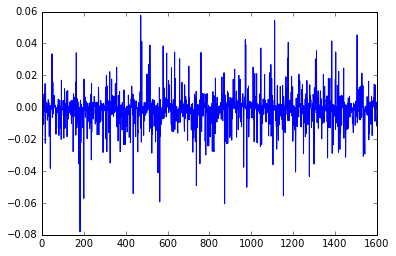

In [13]:
plt.plot(weights['layer_5']['param_2'])

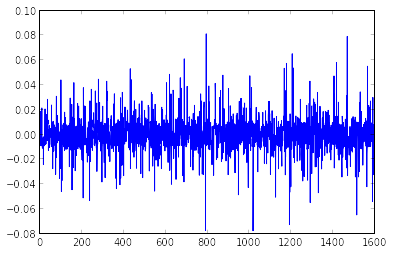

In [48]:
plt.plot(weights['layer_5']['param_5'])

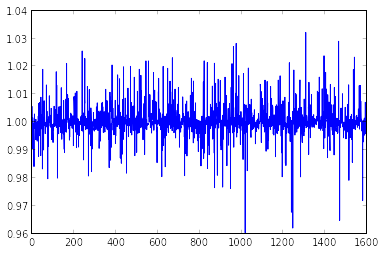

In [51]:
plt.plot(weights['layer_5']['param_8'])

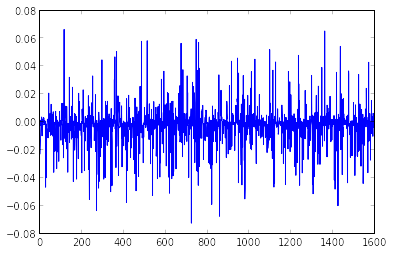

In [54]:
plt.plot(weights['layer_5']['param_11'])

# Visualizing 1600x1600 weights (1600 = number of hidden units)

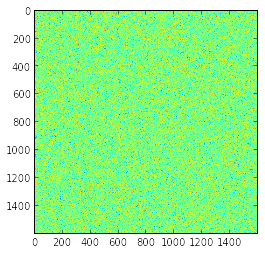

In [55]:
plt.imshow(weights['layer_5']['param_1'])

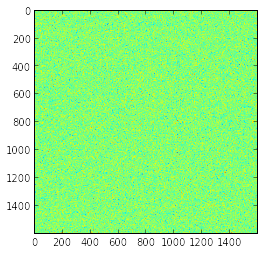

In [57]:
plt.imshow(weights['layer_5']['param_4'])

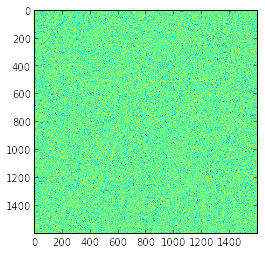

In [58]:
plt.imshow(weights['layer_5']['param_7'])

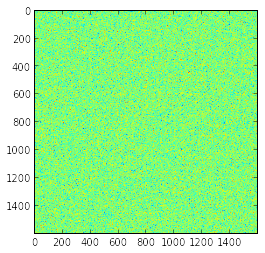

In [59]:
plt.imshow(weights['layer_5']['param_10'])

# Visualizing Rectangular weights

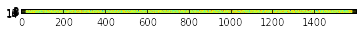

In [61]:
plt.imshow(weights['layer_5']['param_0'])

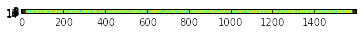

In [62]:
plt.imshow(weights['layer_5']['param_3'])

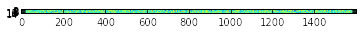

In [65]:
plt.imshow(weights['layer_5']['param_6'])

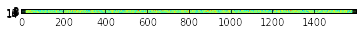

In [68]:
plt.imshow(weights['layer_5']['param_9'])

#Visualizing LSTM outputs

In [15]:
memories = False #set to true if you want to return the memories (hidden states)
cell_index = 4
numTime = 152

In [23]:
def load_Data():
    naturalscenes_test = loadexpt(cell_index, 'naturalscene', 'test', 40)
    X_test = naturalscenes_test.X
    y_test = naturalscenes_test.y
    numTest = (int(X_test.shape[0]/numTime))*numTime
    X_test = X_test[:numTest]
    y_test = y_test[:numTest]
    X_test = np.reshape(X_test, (int(numTest/numTime), numTime, 40, 50, 50))
    y_test = np.reshape(y_test, (int(numTest/numTime), numTime, 1))
    return X_test, y_test

In [24]:
def get_outputs(X_batch):
    l2_reg = 0.01
    stim_shape = (numTime, 40, 50, 50)
    RMSmod = RMSprop(lr=0.001, rho=0.99, epsilon=1e-6)
    num_filters = (8, 16)
    filter_size = (13, 13)
    weight_init = 'he_normal'
    batchsize = 100
    model = Sequential()
    # first convolutional layer
    model.add(TimeDistributedConvolution2D(num_filters[0], filter_size[0], filter_size[1],
                                 input_shape=stim_shape,
                                 border_mode='same', subsample=(1,1),
                                 W_regularizer=l2(l2_reg)))

    #Add relu activation separately for threshold visualizations
    model.add(Activation('relu'))
    # max pooling layer
    model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2), ignore_border=True))

    # flatten
    model.add(TimeDistributedFlatten())

    # Add dense (affine) layer with relu activation
    model.add(TimeDistributedDense(num_filters[1], W_regularizer=l2(l2_reg), activation='relu'))
    # Add LSTM, forget gate bias automatically initialized to 1, default weight initializations recommended
    model.add(LSTM(100*num_filters[1], return_sequences=True))

    # # Add a final dense (affine) layer with softplus activation
    model.add(TimeDistributedDense(1, init=weight_init, W_regularizer=l2(l2_reg), activation='softplus'))
    model.compile(loss='poisson_loss', optimizer=RMSmod)
    model.load_weights(weights_dir)
    if not memories:
        get_outputs = theano.function([model.layers[0].input], model.layers[5].get_output(train=False))
        outputs = get_outputs(X_batch)
    else:
        model2 = Sequential()
        model2.add(TimeDistributedConvolution2D(num_filters[0], filter_size[0], filter_size[1],
                                 input_shape=stim_shape, weights=model.layers[0].get_weights(),
                                 border_mode='same', subsample=(1,1),
                                 W_regularizer=l2(l2_reg)))

        #Add relu activation separately for threshold visualizations
        model2.add(Activation('relu'))
        # max pooling layer
        model2.add(TimeDistributedMaxPooling2D(pool_size=(2, 2), ignore_border=True))

        # flatten
        model2.add(TimeDistributedFlatten())

        # Add dense (affine) layer with relu activation
        model2.add(TimeDistributedDense(num_filters[1], weights=model.layers[4].get_weights(), W_regularizer=l2(l2_reg), activation='relu'))
        # Add LSTM, forget gate bias automatically initialized to 1, default weight initializations recommended
        model2.add(LSTMMem(100*num_filters[1], weights=model.layers[5].get_weights(), return_memories=True))
        model2.compile(loss='poisson_loss', optimizer=RMSmod)
        get_outputs = theano.function([model2.layers[0].input], model2.layers[5].get_output(train=False))
        outputs = get_outputs(X_batch)
    return outputs


In [25]:
X_test, y_test = load_Data()
outputs = get_outputs(X_test)
print outputs.shape

Loading testing data... Done.


KeyError: 'dn52e67k.sunet'

# Low/High Contrast Stimulus

In [5]:
period = 0.64 # to get it into 152 timesteps after rolling window
sample_rate = 100 # 100 Hz
low_contrast = 0.1
high_contrast = 1.0

In [28]:
flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])

/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [2]:
def get_full_field_flicker(period=0.64, low_contrast=0.1, high_contrast=1.0):
    sample_rate = 100
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    
    # Convert flicker sequence into full field movie
    full_field_flicker = np.outer(flicker_sequence, np.ones((1,50,50)))
    full_field_flicker = full_field_flicker.reshape((flicker_sequence.shape[0], 50, 50))

    # Convert movie to 400ms long samples in the correct format for our model
    full_field_movies = rolling_window(full_field_flicker, 40)
    full_field_movies = np.rollaxis(full_field_movies, 2)
    full_field_movies = np.rollaxis(full_field_movies, 3, 1)
    length = (int(full_field_movies.shape[0]/numTime))*numTime #reshape to include timesteps for rnn
    full_field_movies = full_field_movies[:length]
    rnn_full_field_movies = np.reshape(full_field_movies, (int(length/numTime), numTime, 40, 50, 50))
    return rnn_full_field_movies

def rolling_window(array, window, time_axis=0):
    """
    Make an ndarray with a rolling window of the last dimension

    Parameters
    ----------
    array : array_like
        Array to add rolling window to

    window : int
        Size of rolling window

    time_axis : 'first' or 'last', optional
        The axis of the time dimension (default: 'first')

    Returns
    -------
    Array that is a view of the original array with a added dimension
    of size `window`.

    Examples
    --------
    >>> x=np.arange(10).reshape((2,5))
    >>> rolling_window(x, 3)
    array([[[0, 1, 2], [1, 2, 3], [2, 3, 4]],
               [[5, 6, 7], [6, 7, 8], [7, 8, 9]]])
    Calculate rolling mean of last dimension:
    >>> np.mean(rolling_window(x, 3), -1)
    array([[ 1.,  2.,  3.],
               [ 6.,  7.,  8.]])

    """

    # flip array dimensinos if the time axis is the first axis
    if time_axis == 0:
        array = array.T

    elif time_axis == -1:
        pass

    else:
        raise ValueError("Time axis must be 0 or -1")

    assert window >= 1, "`window` must be at least 1."
    assert window < array.shape[-1], "`window` is too long."

    # with strides
    shape = array.shape[:-1] + (array.shape[-1] - window, window)
    strides = array.strides + (array.strides[-1],)
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

# Get Cell 4 natural scenes (Test CC ~0.72) responses to low/high contrast stimulus

In [10]:
ntrials = 2000
period = 1
sample_rate = 100
batch_size = 26
#nsamples = 3*period*sample_rate - 40
#assert nsamples % batch_size == 0, 'nsamples must be divisible by batch_size'

In [15]:
lstm_responses = np.zeros((ntrials, numTime)) #since we technically have only 1 samples of 152 timesteps

In [12]:
print theano.config.floatX

float32


In [13]:
l2_reg = 0.01
stim_shape = (numTime, 40, 50, 50)
RMSmod = RMSprop(lr=0.001, rho=0.99, epsilon=1e-6)
num_filters = (8, 16)
filter_size = (13, 13)
weight_init = 'he_normal'
batchsize = 100
model = Sequential()
# first convolutional layer
model.add(TimeDistributedConvolution2D(num_filters[0], filter_size[0], filter_size[1],
                             input_shape=stim_shape,
                             border_mode='same', subsample=(1,1),
                             W_regularizer=l2(l2_reg)))

#Add relu activation separately for threshold visualizations
model.add(Activation('relu'))
# max pooling layer
model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2), ignore_border=True))

# flatten
model.add(TimeDistributedFlatten())

# Add dense (affine) layer with relu activation
model.add(TimeDistributedDense(num_filters[1], W_regularizer=l2(l2_reg), activation='relu'))
# Add LSTM, forget gate bias automatically initialized to 1, default weight initializations recommended
model.add(LSTM(100*num_filters[1], return_sequences=True))

# # Add a final dense (affine) layer with softplus activation
model.add(TimeDistributedDense(1, init=weight_init, W_regularizer=l2(l2_reg), activation='softplus'))
model.compile(loss='poisson_loss', optimizer=RMSmod)
model.load_weights(weights_dir)

In [ ]:
for n in range(ntrials):
    if n % 50 == 0:
        print 'Starting %d trial out of %d.' %(n,ntrials)
    stimulus = get_full_field_flicker()
    predictions = model.predict(stimulus)
    lstm_responses[n, :] = predictions.flatten()

In [22]:
lstm_responses = pickle.load(open("lstm_responses.p", "rb"))

In [47]:
average_lstm_response = np.mean(lstm_responses, 0)

In [24]:
flicker_sequences = []
for i in range(100):
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    flicker_sequences.append(flicker_sequence)

/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


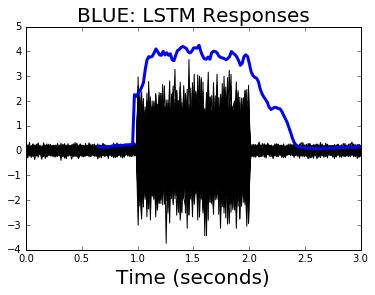

In [59]:
# Plot multiple flicker sequences
for flicker in flicker_sequences:
    plt.plot(np.linspace(0,3,192), flicker, 'k')

# Plot average LSTM response
plt.plot(np.linspace(0.65,3,147), average_lstm_response[5:], 'b', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('BLUE: LSTM Responses', fontsize=20)
#plt.savefig('Contrast Adaptation - natural scenes LN model.png', dpi=500)

# Get multi-cell responses (natural scenes) to low/high contrast stimulus (cell 4) Test CC ~0.56

In [4]:
data_dir = '/Users/Aran/Dropbox/deep-retina/saved/lenna.salamander/2016-01-12 15.22.21 lstmstateful/'
weights_dir = data_dir + 'epoch081_iter06350_weights.h5'

In [6]:
numTime = 152
ntrials = 2000
period = 1
sample_rate = 100
batch_size = 30
lstm_responses = np.zeros((ntrials, numTime)) #since we technically have only 1 samples of 152 timesteps

In [11]:
nout = len([0, 1, 2, 3, 4])
l2_reg = 0.01
stim_shape = (numTime, 40, 50, 50)
num_filters = (8, 16)
filter_size = (13, 13)
weight_init = 'he_normal'
batchsize = 100
model = Sequential()
# first convolutional layer
model.add(TimeDistributedConvolution2D(num_filters[0], filter_size[0], filter_size[1],
                             input_shape=stim_shape,
                             border_mode='same', subsample=(1,1),
                             W_regularizer=l2(l2_reg)))

#Add relu activation separately for threshold visualizations
model.add(Activation('relu'))
# max pooling layer
model.add(TimeDistributedMaxPooling2D(pool_size=(2, 2)))

# flatten
model.add(TimeDistributedFlatten())

# Add dense (affine) layer with relu activation
model.add(TimeDistributedDense(num_filters[1], W_regularizer=l2(l2_reg), activation='relu'))
# Add LSTM, forget gate bias automatically initialized to 1, default weight initializations recommended
model.add(LSTM(100*num_filters[1], return_sequences=True))

# # Add a final dense (affine) layer with softplus activation
model.add(TimeDistributedDense(nout, init=weight_init, W_regularizer=l2(l2_reg), activation='softplus'))
model.compile(loss='poisson_loss', optimizer='adam')
model.load_weights(weights_dir)

In [15]:
for n in range(ntrials):
    if n % 50 == 0:
        print 'Starting %d trial out of %d.' %(n,ntrials)
    stimulus = get_full_field_flicker()
    predictions = model.predict(stimulus)
    predictions = predictions[:, :, 4] #just get cell 4 responses
    lstm_responses[n, :] = predictions.flatten()

Starting 0 trial out of 2000.


/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [16]:
lstm_responses = pickle.load(open("cell4_multicell_lstm_responses.p", "rb"))

In [17]:
average_lstm_response = np.mean(lstm_responses, 0)

In [20]:
flicker_sequences = []
for i in range(100):
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    flicker_sequences.append(flicker_sequence)

/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


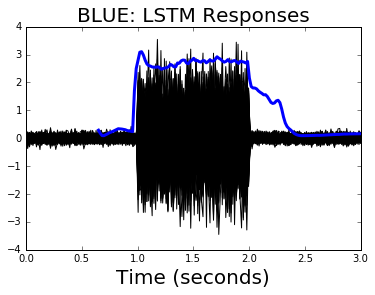

In [21]:
# Plot multiple flicker sequences
for flicker in flicker_sequences:
    plt.plot(np.linspace(0,3,192), flicker, 'k')

# Plot average LSTM response
plt.plot(np.linspace(0.65,3,147), average_lstm_response[5:], 'b', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('BLUE: LSTM Responses', fontsize=20)

# Get multi-cell responses (natural scenes) to low/high contrast stimulus (cell 4) Test CC ~0.622 with fixed CNN feature vector as input

In [2]:
from deepretina.modeltools import load_model, load_partial_model
# Multi-cell CNN trained on natural scenes
natural_model_path = '/Users/Aran/Dropbox/deep-retina/saved/lenna.nirum/2015-12-13 00.27.52 convnet/'
natural_weight_name = 'epoch098_iter07000_weights.h5'
natural_multimodel = load_model(natural_model_path, natural_weight_name)
natural_activations = load_partial_model(natural_multimodel, 4)

In [4]:
def get_cnn_full_field_flicker(period=1, low_contrast=0.1, high_contrast=1.0):
    sample_rate = 100
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    
    # Convert flicker sequence into full field movie
    full_field_flicker = np.outer(flicker_sequence, np.ones((1,50,50)))
    full_field_flicker = full_field_flicker.reshape((flicker_sequence.shape[0], 50, 50))

    # Convert movie to 400ms long samples in the correct format for our model
    full_field_movies = rolling_window(full_field_flicker, 40)
    full_field_movies = np.rollaxis(full_field_movies, 2)
    full_field_movies = np.rollaxis(full_field_movies, 3, 1)
    return full_field_movies

In [8]:
data_dir = '/Users/Aran/Dropbox/deep-retina/saved/lenna.salamander/2016-01-18 00.48.40 fixedlstm/'
weights_dir = data_dir + 'epoch350_iter01050_weights.h5' #weights for epoch 376 where 0.622 was attained were not saved
nout = len([0, 1, 2, 3, 4])
numTime = 952
l2_reg = 0.01
num_filters = (8, 16)
filter_size = (13, 13)
weight_init = 'he_normal'
batchsize = 100
model = Sequential()

#Add relu activation separately for threshold visualizations
model.add(Activation('relu', input_shape=(numTime, num_filters[1])))

# Add LSTM, forget gate bias automatically initialized to 1, default weight initializations recommended
model.add(LSTM(100*num_filters[1], return_sequences=True))

# # Add a final dense (affine) layer with softplus activation
model.add(TimeDistributedDense(nout, init=weight_init, W_regularizer=l2(l2_reg), activation='softplus'))
model.compile(loss='poisson_loss', optimizer='adam')
model.load_weights(weights_dir)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '6742' (I am process '738')


KeyError: "Can't open attribute (Can't locate attribute: 'nb_layers')"

In [ ]:
ntrials = 2000
sample_rate = 100
period = np.ceil((numTime + 40.)/(3*sample_rate))
lstm_responses = np.zeros((ntrials, numTime)) #since we technically have one sample of 952 timesteps
for n in range(ntrials):
    if n % 50 == 0:
        print 'Starting %d trial out of %d.' %(n,ntrials)
    stimulus = get_cnn_full_field_flicker(period=period, low_contrast=0.1, high_contrast=1.0)
    affine_preds = natural_activations(stimulus)
    length = (int(affine_preds.shape[0]/numTime))*numTime #reshape to include timesteps for rnn
    affine_preds = affine_preds[:length]
    rnn_input = np.reshape(affine_preds, (int(length/numTime), numTime, 16))
    predictions = model.predict(rnn_input)
    predictions = predictions[:, :, 4] #just get cell 4 responses
    lstm_responses[n, :] = predictions.flatten()

In [71]:
lstm_responses = pickle.load(open("cell4_multicell_fixedlstm_responses.p", "rb"))
average_lstm_response = np.mean(lstm_responses, 0)

In [60]:
flicker_sequences = []
low_contrast = 0.1
high_contrast = 1.0
ntrials = 2000
sample_rate = 100
numTime = 952
period = np.ceil((numTime + 40.)/(3*sample_rate))
for i in range(100):
    flicker_sequence = np.hstack([low_contrast*np.random.randn(period*sample_rate), 
                               high_contrast*np.random.randn(period*sample_rate),
                              low_contrast*np.random.randn(period*sample_rate)])
    flicker_sequences.append(flicker_sequence)

/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Aran/Desktop/adaptation/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


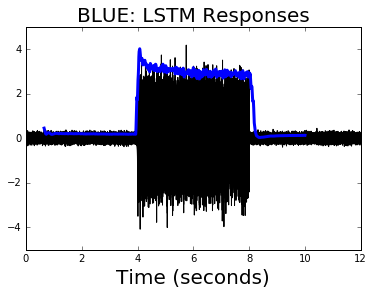

In [76]:
# Plot multiple flicker sequences
for flicker in flicker_sequences:
    plt.plot(np.linspace(0,12,1200), flicker, 'k')

# Plot average LSTM response
plt.plot(np.linspace(0.65,10,912), average_lstm_response[40:], 'b', linewidth=3)
plt.xlabel('Time (seconds)', fontsize=20)
plt.title('BLUE: LSTM Responses', fontsize=20)

# LSTM performance vs timesteps: multi-cell and natural scenes with fixed CNN feature vector as input: 50 epochs training, he normal initialization, adam optimizer

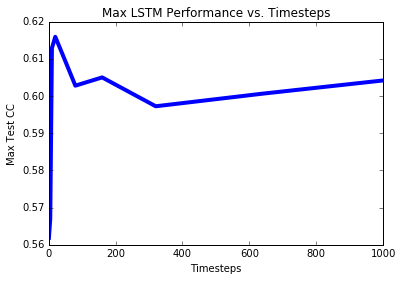

In [2]:
timesteps = [1, 5, 10, 20, 40, 80, 160, 320, 640, 1000]
testcc = [0.561874994, 0.566935455, 0.612876339, 0.615914423, 0.611572801, 0.602780552, 0.604998847, 0.597239874, 0.60063724, 0.604186998]
plt.plot(timesteps, testcc, linewidth=4.0)
plt.xlabel("Timesteps")
plt.ylabel("Max Test CC")
plt.title("Max LSTM Performance vs. Timesteps")

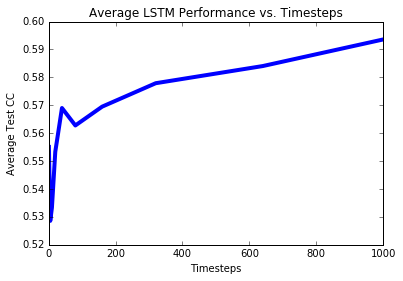

In [3]:
averagetestcc = [0.555089844, 0.528577067, 0.53330956, 0.553330909, 0.569026652, 0.562773196, 0.569516936, 0.577916176, 0.58407209, 0.593615901]
plt.plot(timesteps, averagetestcc, linewidth=4.0)
plt.xlabel("Timesteps")
plt.ylabel("Average Test CC")
plt.title("Average LSTM Performance vs. Timesteps")

# Hidden state dimension vs. performance

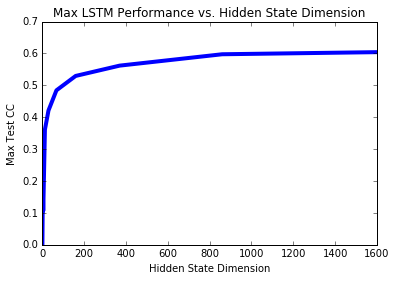

In [6]:
hiddenunits = [1, 3, 5, 13, 30, 68, 160, 370, 860, 1600]
testcc = [0.0035118, 0.169159498, 0.106742674, 0.361391905, 0.421243508, 0.484423833, 0.529606467, 0.561910872, 0.597577803, 0.604186998]
plt.plot(hiddenunits, testcc, linewidth=4.0)
plt.xlabel("Hidden State Dimension")
plt.ylabel("Max Test CC")
plt.title("Max LSTM Performance vs. Hidden State Dimension")

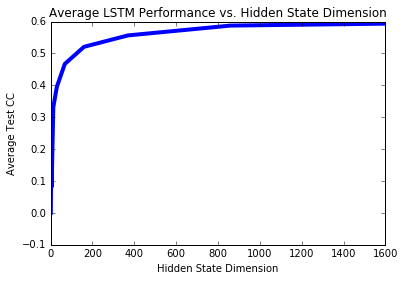

In [7]:
averagetestcc = [-0.000101142, 0.130417403, 0.082262784, 0.331422539, 0.395428723, 0.467194838, 0.521007208, 0.556707963, 0.587499728, 0.593561342]
plt.plot(hiddenunits, averagetestcc, linewidth=4.0)
plt.xlabel("Hidden State Dimension")
plt.ylabel("Average Test CC")
plt.title("Average LSTM Performance vs. Hidden State Dimension")

# Visualizing LSTM Hidden States from multi-cell model (natural scenes) to low/high contrast stimulus (cell 4) Test CC ~0.622 with fixed CNN feature vector as input

In [3]:
hidden_states = pickle.load(open("lstm_hiddenstates.p", "rb"))

In [4]:
print hidden_states.shape

(952, 1600)


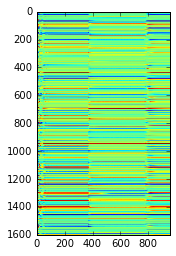

In [6]:
plt.imshow(hidden_states.T)